<td>
<a href="https://colab.research.google.com/github/raoulg/MADS-DAV/blob/main/notebooks/6.4_huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</td>

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
from loguru import logger

In [2]:
import tomllib
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")
df = pd.read_parquet(datafile)
#df.head()

# Mapping text to a semantic vectorspace

Instead of mapping the result of the non-linear transformations to just one dimension of sentiment, we can pick a more general model that doesnt do this. This model is "just" trained on a lot of textual data, and the output vectors will represent the meaning of the text in a high dimensional space. This can be used to compare the meaning of different texts, or to use as input for a classifier.

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(f"Embedding shape: {embeddings.shape}")

As you can see, we input two sentences, and the output in this case are two vectors, 384 dimensions each. 

I will try to filter the text that are too short (eg more than just "hi" and "hello") to see if we can get a bit more interesting results.

<Axes: xlabel='message_length', ylabel='Count'>

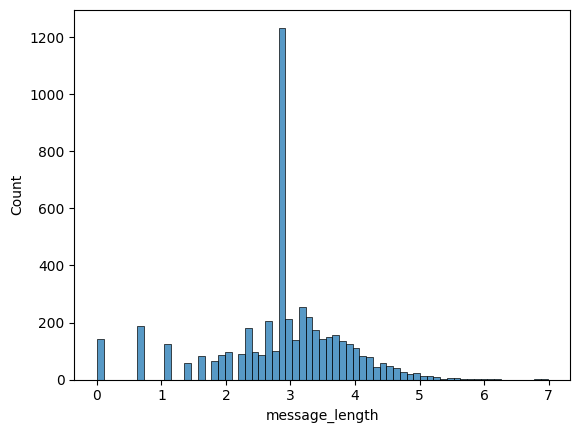

In [4]:
df['message_length'] = df['message'].str.len()
sns.histplot(x=np.log(df["message_length"]))

<img src="../img/message_length.png" width=450 height=400 />

My dataset seems to have a median message length of log(x) = 4, so lets take 5 as a cutoff

In [7]:
#define Embedding class
from dataclasses import dataclass
import numpy as np

@dataclass
class Embedding:
    metadata: list
    vectors: np.ndarray

    def __getitem__(self, idx: int) -> tuple:
        return (self.vectors[idx], self.metadata[idx])

    def __len__(self) -> int:
        return len(self.metadata)

    def __repr__(self) -> str:
        return f"Embedding, dims={self.vectors.shape}"

In [23]:
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

class BasicPlot:
    """
    A base class for creating basic plots using Matplotlib and Seaborn.

    This class provides common functionalities for initializing plot parameters,
    including titles, labels, and saving plots. It serves as a foundation for
    more specific plot types by encapsulating shared behaviors.

    Attributes:
    config (Config): Configuration object containing settings for the plot.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    filename (str): Filename for saving the plot.
    show_legend (bool): Flag indicating whether to display the legend.

    Methods:
    __call__(data, *args, **kwargs): Creates the plot with the provided data.
    show_plot(): Displays the plot with the configured settings.
    save(): Saves the plot to the specified filename.
    plot(data, *args, **kwargs): Defines how to create the plot, empty in the basicPlot class.
    """    
    def __init__(self, title_fig: str, xlabel: str, ylabel: str, filename: str, figsize=(10, 5), show_legend: bool = True, legend_title:str=""):
        self.title_fig = title_fig
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.filename = filename
        self.show_legend = show_legend
        self.legend_title = legend_title
        #define basic custom colors for plots
        self.color = "gray"
        self.color_highlight = "salmon"
        #set gray scala colors as default
        #self.custom_colors = color_palette 
    
    def plot(self, data: pd.DataFrame):
        #to define for each plot
        pass

    def show_plot(self):
        print(self.title_fig)
        plt.title(self.title_fig)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.tight_layout()
        if self.show_legend:
            plt.legend(title=self.legend_title, bbox_to_anchor=(1.0, 1), loc='upper left')
        plt.show()
        plt.close()  # Close the figure to free up memory

    @logger.catch
    def save(self):
        filepath = Path("../img") / Path(self.filename)
        plt.savefig(filepath, bbox_inches='tight', transparent=False)
        logger.success(f"Plot saved to: {filepath}")


class ScatterPlot(BasicPlot):
    def __init__(self, title_fig: str, xlabel: str, ylabel: str, filename: str, custom_palette: list, metadata_lb: str = "author", alpha: float = 0.9):
        super().__init__(title_fig, xlabel, ylabel, filename)
        self.custom_palette = custom_palette
        self.metadata_lb = metadata_lb
        self.alpha = alpha

    def plot(self, X: np.ndarray, emb):
        labels = [emb.metadata[i][self.metadata_lb] for i in range(len(emb.metadata))]
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette=self.custom_palette, alpha=self.alpha)

        # Set the title, xlabel, and ylabel
        plt.title(self.title_fig)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)

        # Set ticks and grid
        plt.xticks(np.arange(np.min(X[:, 0]), np.max(X[:, 0]) + 1, step=10))  # Adjust steps for visualization
        plt.yticks(np.arange(np.min(X[:, 1]), np.max(X[:, 1]) + 1, step=10))
        plt.grid(True)

        # Show legend if applicable
        if self.show_legend:
            plt.legend(title=self.legend_title, bbox_to_anchor=(1.0, 1), loc='upper left')

        plt.tight_layout()


class TSNEPlotVisualizer:
    """
    Visualizes t-SNE scatter plots.

    Args:
        preprocessor (Preprocessor): Class responsible for preprocessing steps.
    """
    def __init__(self, custom_palette: list = 'dark'):
        self.custom_palette = custom_palette

    def create_embedding(self, subset, model):   
        metadata = {}
        text = []
        for idx, row in subset.iterrows():
            author = row["author"]
            message = row["message"]
            timestamp = row["timestamp"]
            topic = row["topic"]
            language = row["language"]
            age = row["age"]
            metadata[idx] = {"author": author, "message": message, "timestamp": timestamp, "topic": topic, 
            "language": language, 'age': age}
            text.append(message)
        #embed text
        vectors = model.encode(text)
        print(vectors.shape)
        return Embedding(metadata, vectors)

    def fit_tsne(self, emb, n_components=2, learning_rate=200, perplexity=30, n_iter=1000):
        #tsne = TSNE(n_components=2)
        tsne =TSNE(n_components=2, learning_rate=learning_rate, perplexity=perplexity, n_iter=n_iter)
        X = tsne.fit_transform(emb.vectors)
        return X

    # def visualization_tsne(self):
    #     """Creates a t-SNE scatter plot visualization."""
    #     # Example of preprocessing step, assuming you have a method to get the t-SNE data
    #     X, emb = self.preprocess_week5()  

    #     scatter_plot = ScatterPlot(
    #         title_fig='t-SNE Scatter Plot',
    #         xlabel='t-SNE Component 1',
    #         ylabel='t-SNE Component 2',
    #         filename='tsne_plot.png',
    #         custom_palette= 'dark',
    #         metadata_lb= "author"  # You can adjust this to whatever metadata you need
    #     )
    
    def preprocess_week5(self, subset:pd.DataFrame):
        """
        Preprocess the data for week 5 by creating embeddings and applying t-SNE.

        Args:
            subset (pd.DataFrame): The subset of data to be processed.

        Returns:
            tuple: A tuple containing:
                - X (np.ndarray): The 2D representation of the data after t-SNE transformation.
                - emb (np.ndarray): The embeddings generated from the input subset.
        """
        # Load the pre-trained SentenceTransformer model
        model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        # Create embeddings for the input subset using the loaded model
        emb = self.create_embedding(subset, model)
        # Apply t-SNE to the embeddings to reduce dimensionality for visualization
        X = self.fit_tsne(emb, learning_rate=300, perplexity=15, n_iter=2000)
        return X, emb



In [ ]:
# Processing pipeline
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# Select subset with verbal messages
subset_verbal = df[df["language"] != 'Non-verbal'].reset_index(drop=True)
# Select subset with message log length above 3
subset = subset_verbal[np.log(subset_verbal["message_length"]) >= 3].reset_index(drop=True)

In [25]:
visualizer = TSNEPlotVisualizer()

# Preprocessing step for t-SNE data
X, emb = visualizer.preprocess_week5(subset)  # Replace with actual method to get X and emb

(1930, 384)


Gesproken onderwerpen zijn essentieel


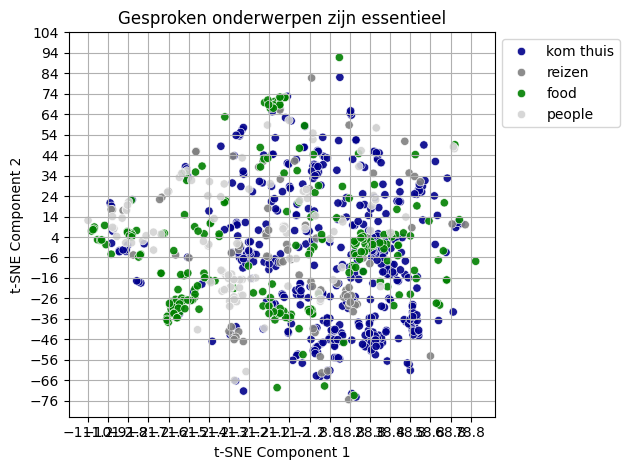

In [36]:
custom_colors = ['darkblue',  'gray', 'green', 'lightgray', ]
scatter_plot = ScatterPlot(
            title_fig='Gesproken onderwerpen zijn essentieel',
            xlabel='t-SNE Component 1',
            ylabel='t-SNE Component 2',
            filename='tsne_plot_topics.png',
            custom_palette=custom_colors,
            metadata_lb="topic"  # You can adjust this to whatever metadata you need
        )
scatter_plot.plot(X, emb)
scatter_plot.show_plot()



Taalstructuren: voedsel gesprekken zijn uitgesproken Italiaans


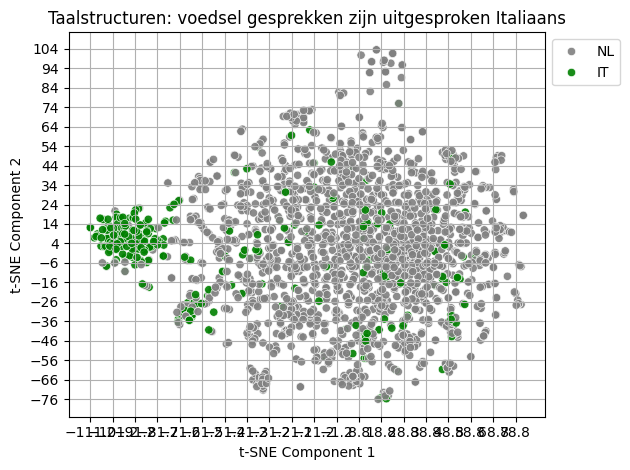

In [44]:


        scatter_plot2 = ScatterPlot(
            title_fig='Taalstructuren: voedsel gesprekken zijn uitgesproken Italiaans',
            xlabel='t-SNE Component 1',
            ylabel='t-SNE Component 2',
            filename='tsne_plot_languages.png',
            custom_palette=['gray',  'green'],
            metadata_lb="language"  # You can adjust this to whatever metadata you need
        )

        scatter_plot2.plot(X, emb)
        scatter_plot2.show_plot()

In [470]:
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE


def create_embedding(subset, model):   
    metadata = {}
    text = []
    for idx, row in subset.iterrows():
        author = row["author"]
        message = row["message"]
        timestamp = row["timestamp"]
        topic = row["topic"]
        language = row["language"]
        age = row["age"]
        metadata[idx] = {"author": author, "message": message, "timestamp": timestamp, "topic": topic, 
        "language": language, 'age': age}
        text.append(message)
    #embed text
    vectors = model.encode(text)
    print(vectors.shape)
    return Embedding(metadata, vectors)

def fit_tsne(emb, n_components=2, learning_rate=200, perplexity=30, n_iter=1000):
    #tsne = TSNE(n_components=2)
    tsne =TSNE(n_components=2, learning_rate=learning_rate, perplexity=perplexity, n_iter=n_iter)
    X = tsne.fit_transform(emb.vectors)
    return X

def plot_tsne(X, custom_palette:list, metadata_lb="author", alpha=0.9, filename="visualization_topics.png"):
    plt.figure(figsize=(7, 4))
    labels = [emb.metadata[i][metadata_lb] for i in range(len(emb.metadata))]
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette=custom_palette, alpha=alpha)
    # Increase the number of ticks on the x and y axes
    plt.xticks(np.arange(np.min(X[:, 0]), np.max(X[:, 0]) + 1, step=10))  # Adjust steps for visualization
    plt.yticks(np.arange(np.min(X[:, 1]), np.max(X[:, 1]) + 1, step=10))  
    plt.grid(True)
    plt.legend(title=metadata_lb, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(f'../img/{filename}', bbox_inches='tight', transparent=False)

In [ ]:
def visualization_week5():
    # processing pipeline
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    #select subset with verbal messages
    subset_verbal = df[df["language"] != 'Non-verbal'].reset_index(drop=True)
    #select subset with message log length above 3
    subset = subset_verbal[np.log(subset_verbal["message_length"]) >= 3].reset_index(drop=True)
    #subset_verbal_nl = subset[subset["language"] == 'NL'].reset_index(drop=True)
    #subset_verbal_nl2 = subset[subset["author"].isin(['effervescent-camel', 'nimble-wombat'])].reset_index(drop=True)
    #subset_verbal_it = subset[subset["language"] == 'IT'].reset_index(drop=True)
    emb = create_embedding(subset, model)
    X = fit_tsne(emb, learning_rate=300, perplexity=15, n_iter=2000)
    return X, emb

In [380]:
emb = create_embedding(subset, model)
X = fit_tsne(emb, learning_rate=300, perplexity=15, n_iter=2000)

(1930, 384)


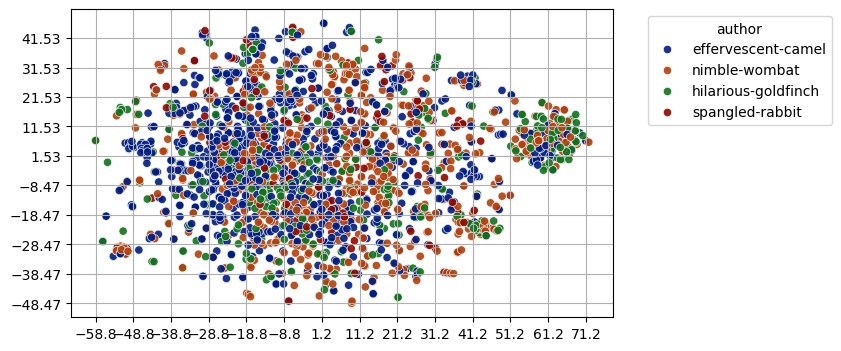

In [471]:
plot_tsne(X, 'dark', 'author')

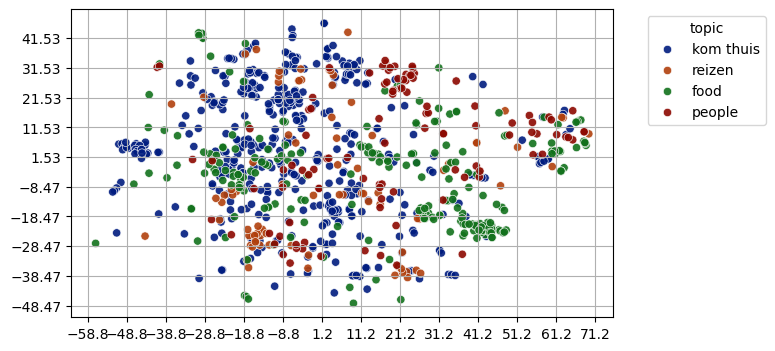

In [474]:
plot_tsne(X, 'dark', 'topic', filename='visualization5_tsne_topics.png')

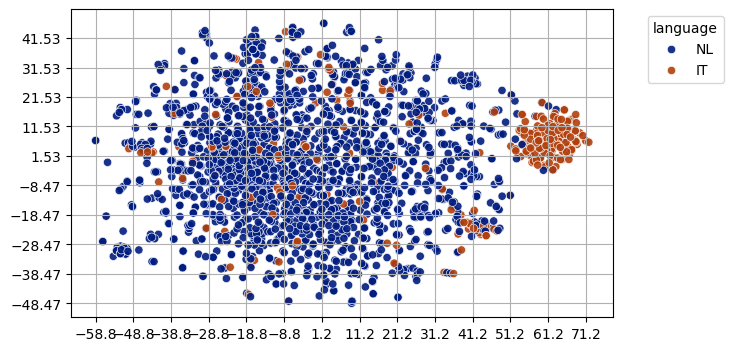

In [473]:
plot_tsne(X, 'dark', 'language', filename='visualization5_tsne_language.png')

In [463]:
tsnet_df = pd.DataFrame(X, columns=['x', 'y'])
#assign coordinate to subset dataset
subset['x']= tsnet_df['x']
subset['y']= tsnet_df['y']

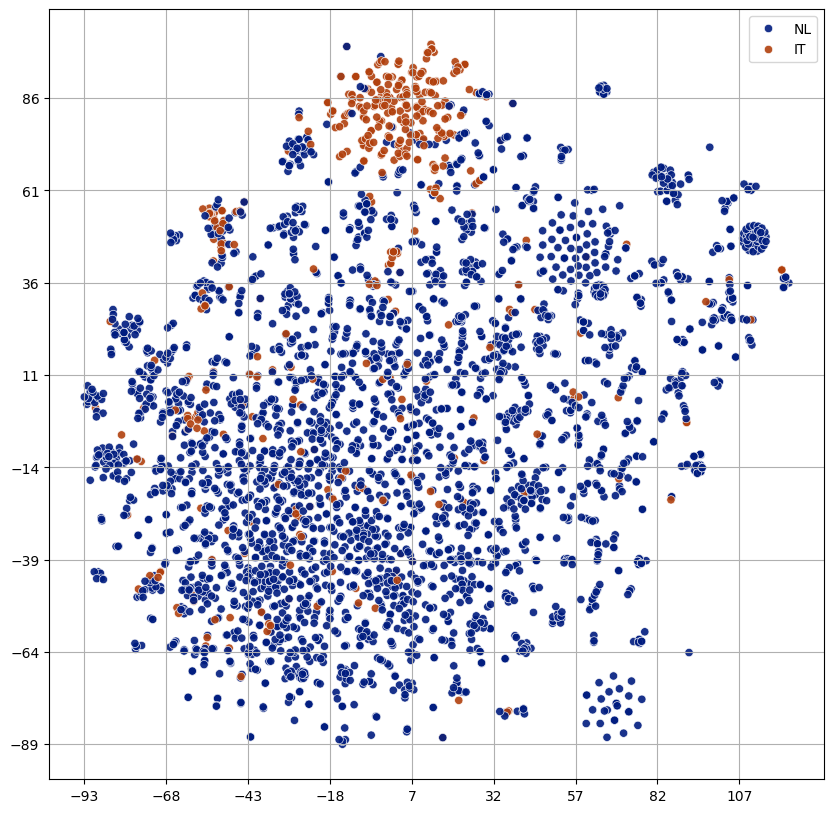

In [370]:
plot_tsne(X, 'dark', 'language')

In [430]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_all_tsne(X,  emb, custom_palette: list='dark',alpha=0.9):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Adjust figsize as needed

    # Extract labels from metadata
    #labels_1 = [emb.metadata[i]['author'] for i in range(len(emb.metadata))]
    #labels = [emb.metadata[i][metadata_lb] for i in range(len(emb.metadata))]
    labels_2 = [emb.metadata[i]['topic'] for i in range(len(emb.metadata))]
    labels_3 = [emb.metadata[i]['language'] for i in range(len(emb.metadata))]
    
    
    # Scatter Plot for Authors
    axs[0, 0].set_title('Scatter Plot Topic')
    axs[0, 0].set_xlabel('X1')
    axs[0, 0].set_ylabel('Y1')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_3, palette=custom_palette, alpha=alpha, ax=axs[0, 0])

    # Scatter Plot for Topics
    axs[0, 1].set_title('Scatter Plot Topic')
    axs[0, 1].set_xlabel('X2')
    axs[0, 1].set_ylabel('Y2')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_2, palette=custom_palette, alpha=alpha, ax=axs[0, 1])

    # # Scatter Plot for Languages
    # axs[1, 0].set_title('Scatter Plot Language')
    # axs[1, 0].set_xlabel('X3')
    # axs[1, 0].set_ylabel('Y3')
    #sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_3, palette=custom_palette, alpha=alpha, ax=axs[1, 0])

    # Set ticks and grid
    plt.xticks(np.arange(np.min(X[:, 0]), np.max(X[:, 0]) + 1, step=25))  # Adjust steps for visualization
    plt.yticks(np.arange(np.min(X[:, 1]), np.max(X[:, 1]) + 1, step=25))
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [432]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_all_tsne(X,  emb, custom_palette: list='dark',alpha=0.9):
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))  # Adjust figsize as needed
    labels_1 = [emb.metadata[i]['topic'] for i in range(len(emb.metadata))]
    labels_2 = [emb.metadata[i]['language'] for i in range(len(emb.metadata))]


    # First scatter plot

    axs[0].set_title('Scatter Plot 1')
    axs[0].set_xlabel('X1')
    axs[0].set_ylabel('Y1')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_1, palette=custom_palette, alpha=alpha, ax=axs[0, 1])

    # Second scatter plot

    axs[1].set_title('Scatter Plot 2')
    axs[1].set_xlabel('X2')
    axs[1].set_ylabel('Y2')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_2, palette=custom_palette, alpha=alpha, ax=axs[0, 1])
    # Set ticks and grid
    plt.xticks(np.arange(np.min(X[:, 0]), np.max(X[:, 0]) + 1, step=25))  # Adjust steps for visualization
    plt.yticks(np.arange(np.min(X[:, 1]), np.max(X[:, 1]) + 1, step=25))
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [409]:
emb = create_embedding(subset, model)
X = fit_tsne(emb, learning_rate=200, perplexity=30, n_iter=1000)

(1930, 384)


In [419]:
def plot_tsne(X, custom_palette:list, metadata_lb="author", alpha=0.9):
    plt.figure(figsize=(8, 6))
    labels = [emb.metadata[i][metadata_lb] for i in range(len(emb.metadata))]
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette=custom_palette, alpha=alpha)
    # Increase the number of ticks on the x and y axes
    plt.xticks(np.arange(np.min(X[:, 0]), np.max(X[:, 0]) + 1, step=10))  # Adjust steps for visualization
    plt.yticks(np.arange(np.min(X[:, 1]), np.max(X[:, 1]) + 1, step=10))  
    plt.grid(True)

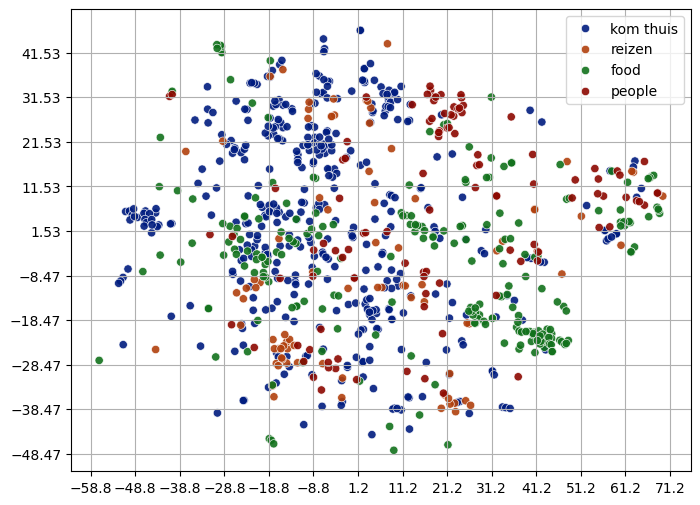

In [426]:
plot_tsne(X, 'dark', 'topic')

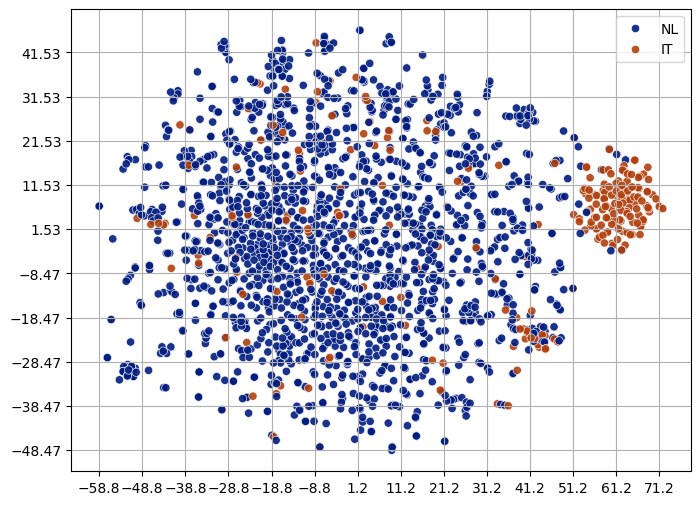

In [421]:
plot_tsne(X, 'dark', 'language')

In [438]:
def plot_all_tsne(X, emb, custom_palette='dark', alpha=0.9):
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))  # 2 rows, 1 column

    # Extract labels from metadata
    labels_1 = [emb.metadata[i]['topic'] for i in range(len(emb.metadata))]
    labels_2 = [emb.metadata[i]['language'] for i in range(len(emb.metadata))]

    # First scatter plot
    axs[0].set_title('Onderwerpen zijn helder')
    axs[0].set_xlabel('X1')
    axs[0].set_ylabel('Y1')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_1, palette=custom_palette, alpha=alpha, ax=axs[0])

    # Second scatter plot
    axs[1].set_title('Talenknobbels')
    axs[1].set_xlabel('X2')
    axs[1].set_ylabel('Y2')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_2, palette=custom_palette, alpha=alpha, ax=axs[1])

    # Set ticks and grid
    plt.xticks(np.arange(np.min(X[:, 0]), np.max(X[:, 0]) + 1, step=25))  # Adjust steps for visualization
    plt.yticks(np.arange(np.min(X[:, 1]), np.max(X[:, 1]) + 1, step=25))
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

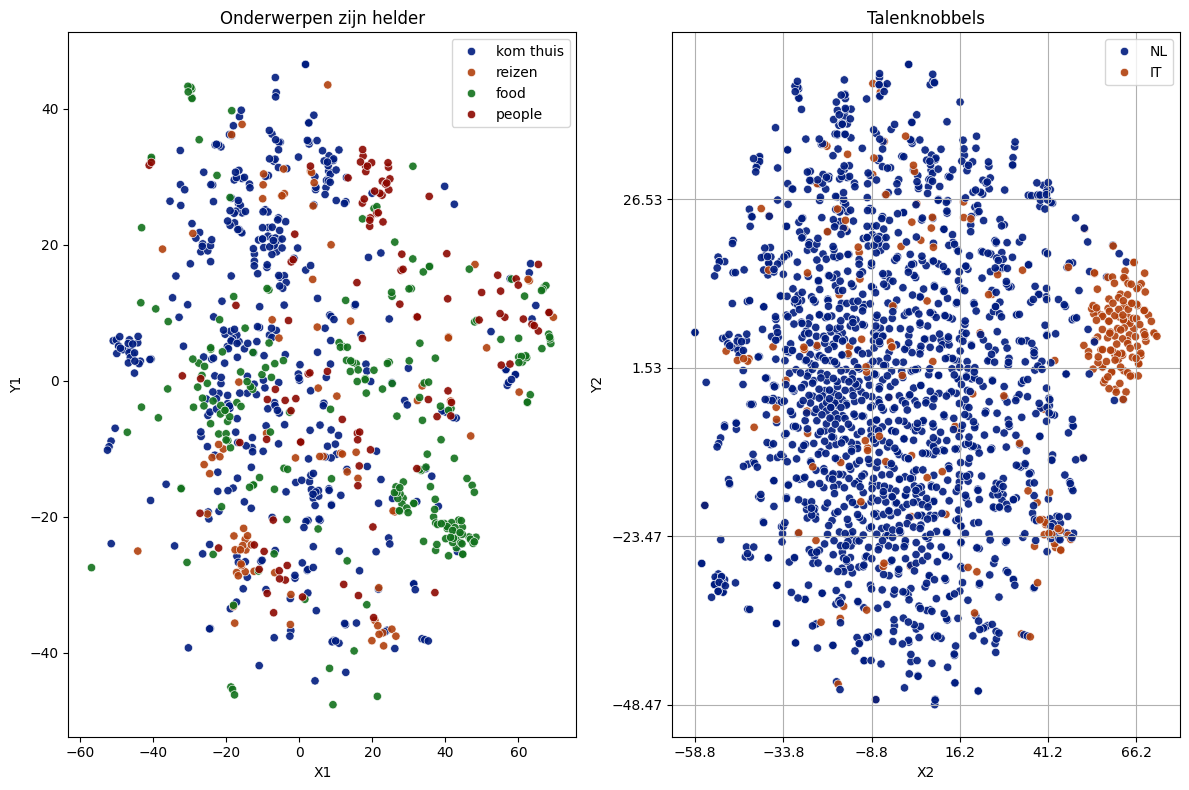

In [439]:
plot_all_tsne(X, emb)

In [366]:
tsnet_df = pd.DataFrame(X, columns=['x', 'y'])
#assign coordinate to subset dataset
subset['x']= tsnet_df['x']
subset['y']= tsnet_df['y']

In [ ]:
subset[(subset["topic"].isnull()) & (np.log(subset["message_length"]) >= 3)]['message']

840                              Kijk wat ik heb gevonden
841     “Ze is net een aap” ik moest echt heel hard la...
842     Ah pensavo che avevi spedito questa foto nel c...
843                             Maartje viene a fare 💃🏼💃🏼
844          Io mi Ho fatto un tost perché non avevo fame
                              ...                        
1932                      Badkamer beneden is bijna klaar
1933    Italië is uitgeschakeld in de EK, even kijken ...
1934                          Ja heb het gezien inderdaad
1935                             Perongeluk slow Motion 😂
1936    Gisteren regende het enorm dus we hebben eigen...
Name: message, Length: 1097, dtype: object

In [ ]:
#subset = df[np.log(df["message_length"]) >= 3].reset_index(drop=True)
#subset

Let's make a new class to keep metadata and the output neatly together.

We can process all data

In [440]:
#subset[(subset['x'] > 103)]

In [388]:
subset['y'].min()

-89.00667

In [390]:
#subset[(subset['y'] > -74.7) & (subset['x'] > 2.5) & (subset['x'] < 22.5) &]

It might be the case that you just get a blob of points with no clear clustering. Some things to consider:

- you might have just too much authors, and if you look more closely you might still find that some authors are more similar than others
- you text messages might overall be too short and too similar. You might need to filter out more messages, or group messages of the same author together and then encode them.
- you might want to add more structure. Eg, label some messages by hand (or with a regex) and use that as a coloring. You might find that some type of message actually do cluster together in a relevant way, just not clustered by author but more by subject.

Please keep in mind that normally, when doing unsupervised clustering, you will have some idea of what you are looking for. For example, you might be looking for fraud, or you are looking for a certain sentiment, or for a specific topic. A typical strategy would be to hand-label a few items and then calculate the distance to find "close" items you didn't label yet. 